In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import skew
from scipy.stats import pearsonr
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
from scipy.stats import ttest_ind
import lazypredict
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [107]:
reservation = pd.read_csv(r"C:\Users\wangj\Desktop\project\Reservation Cancellation\train.csv")
test = pd.read_csv(r"C:\Users\wangj\Desktop\project\Reservation Cancellation\test.csv")

# Exploratory Data Analysis and Data Pre-processing

In [108]:
reservation = reservation.drop("id", axis = 1)
reservation = reservation.drop_duplicates()
reservation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42100 entries, 0 to 42099
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          42100 non-null  int64  
 1   no_of_children                        42100 non-null  int64  
 2   no_of_weekend_nights                  42100 non-null  int64  
 3   no_of_week_nights                     42100 non-null  int64  
 4   type_of_meal_plan                     42100 non-null  int64  
 5   required_car_parking_space            42100 non-null  int64  
 6   room_type_reserved                    42100 non-null  int64  
 7   lead_time                             42100 non-null  int64  
 8   arrival_year                          42100 non-null  int64  
 9   arrival_month                         42100 non-null  int64  
 10  arrival_date                          42100 non-null  int64  
 11  market_segment_

In [109]:
#Check if there are any duplicated rows after droping booking status
reservation[reservation.drop("booking_status", axis = 1).duplicated()]

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
1870,1,0,0,2,2,0,0,377,2018,10,14,0,0,0,0,90.00,0,0
2477,2,0,2,0,0,0,0,275,2018,4,17,0,0,0,0,110.00,0,1
3685,2,0,1,2,0,0,0,224,2017,10,2,0,0,0,0,65.00,0,0
4025,2,0,0,5,0,0,0,230,2018,9,6,1,0,0,0,137.00,0,0
4070,2,0,0,4,0,0,1,213,2018,8,31,1,0,0,0,118.15,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42045,2,0,2,3,0,0,0,118,2018,4,10,1,0,0,0,90.95,0,1
42050,2,0,0,2,0,0,0,322,2018,12,9,0,0,0,0,52.00,0,0
42071,2,0,0,2,2,0,0,257,2018,7,1,0,0,0,0,101.50,0,0
42077,2,0,0,1,0,0,0,131,2018,7,23,1,0,0,0,105.30,1,0


There are 562 duplicated rows which have contradicting booking status. We need to drop them so they don't affect our model performance.

In [110]:
#Randomly selecting contradictory rows to drop
keep_indices = []
for _, status in reservation.groupby(list(reservation.drop("booking_status", axis = 1).columns)):
    if len(status) > 1:
        keep_index = np.random.choice(status.index)
        keep_indices.append(keep_index)
    else:
        keep_indices.append(status.index[0])
reservation = reservation.loc[keep_indices]

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
11331,0,0,0,3,0,0,1,28,2018,6,11,1,0,0,0,108.42,1,0
23226,0,0,0,3,0,0,2,44,2018,2,7,1,0,0,0,66.50,1,0
38402,0,0,0,3,0,0,2,76,2018,9,21,1,0,0,0,127.38,0,0
31375,0,0,0,3,0,0,2,104,2018,12,25,1,0,0,0,91.60,1,0
82,0,0,0,3,0,0,2,156,2018,8,31,1,0,0,0,108.66,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9323,4,0,1,2,0,0,5,40,2018,7,11,1,0,0,0,278.90,0,1
4356,4,0,1,5,0,0,5,5,2018,12,2,1,0,0,0,170.61,1,0
41701,4,0,2,1,0,0,5,7,2018,7,17,1,0,0,0,299.33,2,0
33204,4,0,2,2,0,0,1,37,2018,6,26,1,0,0,0,125.10,0,0


In [111]:
test = test.drop("id", axis = 1)
test[test.duplicated()]

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
488,2,0,1,2,0,0,0,338,2018,10,7,0,0,0,0,80.00,1
930,2,0,1,2,0,0,0,121,2018,6,24,1,0,0,0,90.00,1
1058,2,0,1,2,0,0,0,250,2018,9,26,0,0,0,0,95.00,0
1746,2,0,1,0,0,0,0,111,2018,10,13,0,0,0,0,120.00,0
2707,2,0,1,2,0,0,0,179,2018,9,30,1,0,0,0,113.40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27908,2,0,1,0,1,0,0,149,2018,6,28,1,0,0,0,85.50,0
27933,1,0,0,2,0,0,0,53,2018,10,14,0,0,0,0,120.00,0
27957,2,0,2,3,0,0,0,256,2018,8,31,1,0,0,0,90.95,0
28043,1,0,0,1,0,0,0,53,2018,10,14,0,0,0,0,120.00,0


In [112]:
#Check if train dataset has any data in test dataset
df_merge = pd.merge(reservation, test, on = list(reservation.drop("booking_status", axis = 1).columns), how = "inner")
df_merge

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,1,0,0,1,0,0,0,0,2017,9,8,0,0,0,0,91.20,0,1
1,1,0,0,1,0,0,0,27,2018,6,9,0,0,0,0,120.00,0,1
2,1,0,0,1,0,0,0,55,2018,7,7,2,0,0,0,79.00,0,1
3,1,0,0,1,0,0,0,81,2018,6,23,1,0,0,0,90.90,0,1
4,1,0,0,1,0,0,0,99,2018,2,19,2,0,0,0,80.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,3,0,1,3,0,0,1,48,2018,4,11,1,0,0,0,130.05,0,0
712,3,0,1,3,0,0,1,60,2018,4,25,1,0,0,0,130.48,0,1
713,3,0,1,3,0,0,1,88,2018,10,10,1,0,0,0,151.20,0,0
714,3,0,1,3,0,0,1,128,2018,8,8,1,0,0,0,146.70,2,0


In [113]:
df = pd.concat([reservation, df_merge], ignore_index=True)
reservation = df.drop(list(df[df.duplicated(keep=False)].index))
reservation

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0,0,0,3,0,0,1,28,2018,6,11,1,0,0,0,108.42,1,0
1,0,0,0,3,0,0,2,44,2018,2,7,1,0,0,0,66.50,1,0
2,0,0,0,3,0,0,2,76,2018,9,21,1,0,0,0,127.38,0,0
3,0,0,0,3,0,0,2,104,2018,12,25,1,0,0,0,91.60,1,0
4,0,0,0,3,0,0,2,156,2018,8,31,1,0,0,0,108.66,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41533,4,0,1,2,0,0,5,40,2018,7,11,1,0,0,0,278.90,0,1
41534,4,0,1,5,0,0,5,5,2018,12,2,1,0,0,0,170.61,1,0
41535,4,0,2,1,0,0,5,7,2018,7,17,1,0,0,0,299.33,2,0
41536,4,0,2,2,0,0,1,37,2018,6,26,1,0,0,0,125.10,0,0


We dealt with data leakage by removing rows that are also in test dataset.

In [114]:
#Check if there's any missing values
reservation.isna().sum()

no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

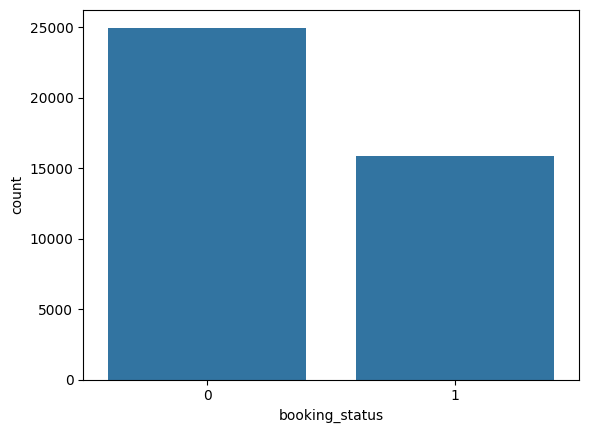

In [115]:
#Check if data is imbalanced
sns.countplot(x = reservation["booking_status"])
plt.show()

In [116]:
reservation["arrival_year_month"] = pd.to_datetime(reservation["arrival_year"].astype(str) +"-"+reservation["arrival_month"].astype(str))
reservation.loc[reservation.arrival_date > reservation.arrival_year_month.dt.days_in_month,"arrival_date"]= reservation.loc[reservation.arrival_date > reservation.arrival_year_month.dt.days_in_month, 'arrival_year_month'].dt.days_in_month
reservation = reservation.drop("arrival_year_month", axis = 1)
reservation["Date"] = pd.to_datetime(reservation["arrival_year"].astype(str) +"-"+reservation["arrival_month"].astype(str)+ "-"+reservation["arrival_date"].astype(str))
us_holidays = holidays.UnitedStates()
reservation["arrival_is_holiday"] = reservation["Date"].apply(lambda x: x in us_holidays).astype(int)
reservation["arrival_is_weekend"] = (reservation["Date"].dt.dayofweek > 4).astype(int)
reservation = reservation.drop(["arrival_date","Date"], axis = 1)
reservation

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,arrival_is_holiday,arrival_is_weekend
0,0,0,0,3,0,0,1,28,2018,6,1,0,0,0,108.42,1,0,0,0
1,0,0,0,3,0,0,2,44,2018,2,1,0,0,0,66.50,1,0,0,0
2,0,0,0,3,0,0,2,76,2018,9,1,0,0,0,127.38,0,0,0,0
3,0,0,0,3,0,0,2,104,2018,12,1,0,0,0,91.60,1,0,1,0
4,0,0,0,3,0,0,2,156,2018,8,1,0,0,0,108.66,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41533,4,0,1,2,0,0,5,40,2018,7,1,0,0,0,278.90,0,1,0,0
41534,4,0,1,5,0,0,5,5,2018,12,1,0,0,0,170.61,1,0,0,1
41535,4,0,2,1,0,0,5,7,2018,7,1,0,0,0,299.33,2,0,0,0
41536,4,0,2,2,0,0,1,37,2018,6,1,0,0,0,125.10,0,0,0,0


In [117]:
reservation[["type_of_meal_plan", "room_type_reserved","arrival_year","arrival_month","market_segment_type"]]=reservation[["type_of_meal_plan","room_type_reserved","arrival_year","arrival_month", "market_segment_type"]].astype("category")
reservation[["required_car_parking_space", "repeated_guest", "arrival_is_holiday", "arrival_is_weekend","booking_status"]] = reservation[["required_car_parking_space", "repeated_guest", "arrival_is_holiday", "arrival_is_weekend","booking_status"]].astype("uint8")
reservation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40822 entries, 0 to 41537
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   no_of_adults                          40822 non-null  int64   
 1   no_of_children                        40822 non-null  int64   
 2   no_of_weekend_nights                  40822 non-null  int64   
 3   no_of_week_nights                     40822 non-null  int64   
 4   type_of_meal_plan                     40822 non-null  category
 5   required_car_parking_space            40822 non-null  uint8   
 6   room_type_reserved                    40822 non-null  category
 7   lead_time                             40822 non-null  int64   
 8   arrival_year                          40822 non-null  category
 9   arrival_month                         40822 non-null  category
 10  market_segment_type                   40822 non-null  category
 11  repeate

# Feature Engineering

In [118]:
reservation = pd.get_dummies(reservation, columns = None ,drop_first=True, dtype='uint8')
reservation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40822 entries, 0 to 41537
Data columns (total 39 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          40822 non-null  int64  
 1   no_of_children                        40822 non-null  int64  
 2   no_of_weekend_nights                  40822 non-null  int64  
 3   no_of_week_nights                     40822 non-null  int64  
 4   required_car_parking_space            40822 non-null  uint8  
 5   lead_time                             40822 non-null  int64  
 6   repeated_guest                        40822 non-null  uint8  
 7   no_of_previous_cancellations          40822 non-null  int64  
 8   no_of_previous_bookings_not_canceled  40822 non-null  int64  
 9   avg_price_per_room                    40822 non-null  float64
 10  no_of_special_requests                40822 non-null  int64  
 11  booking_status      

In [120]:
#Chi-Square Test
for variable in list(reservation.drop("booking_status", axis = 1).select_dtypes(include="uint8").columns):
    table = pd.crosstab(reservation['booking_status'], reservation[variable])
    print(table)
    #chi-square test
    chi2_stat, p_val, dof, expected = chi2_contingency(table)
    print('Chi-squared statistic:', chi2_stat)
    print('p-value:', p_val)
    print('Degrees of freedom:', dof)
    print('Expected Frequencies:\n', expected)
    #Calculate cramer's v
    n = len(reservation)
    r, k = table.shape
    phi = np.sqrt(chi2_stat / (n * (min(r, k) - 1)))
    v = phi / np.sqrt(min(r, k) - 1)
    print("Cramer's V:", v)
    print('\n')

required_car_parking_space      0    1
booking_status                        
0                           24013  947
1                           15748  114
Chi-squared statistic: 361.12876349174667
p-value: 1.5988216167190709e-80
Degrees of freedom: 1
Expected Frequencies:
 [[24311.26745382   648.73254618]
 [15449.73254618   412.26745382]]
Cramer's V: 0.09405543606015285


repeated_guest      0     1
booking_status             
0               23742  1218
1               15851    11
Chi-squared statistic: 766.9521670021657
p-value: 8.26883811497202e-169
Degrees of freedom: 1
Expected Frequencies:
 [[24208.54637205   751.45362795]
 [15384.45362795   477.54637205]]
Cramer's V: 0.13706829173425122


arrival_is_holiday      0    1
booking_status                
0                   24170  790
1                   15551  311
Chi-squared statistic: 53.15049655782181
p-value: 3.0894733493346443e-13
Degrees of freedom: 1
Expected Frequencies:
 [[24286.8100534   673.1899466]
 [15434.1899466   427

We found that chi-square tests may not be reliable for variables type_of_meal_plan_3 and room_type_reserved_6 since 2 of expected frequencies are less than 5.

In [121]:
#Fisher Exact Test
table1 = pd.crosstab(reservation['booking_status'], reservation["type_of_meal_plan_3"])
print(table1)
odds_ratio, p_value = fisher_exact(table1)
print("Odds Ratio:", odds_ratio)
print("p-value:", p_value)
print("\n")

table2 = pd.crosstab(reservation['booking_status'], reservation["room_type_reserved_6"])
print(table2)
odds_ratio, p_value = fisher_exact(table2)
print("Odds Ratio:", odds_ratio)
print("p-value:", p_value)
print("\n")

type_of_meal_plan_3      0  1
booking_status               
0                    24955  5
1                    15861  1
Odds Ratio: 0.31467120610301996
p-value: 0.41522244285488297


room_type_reserved_6      0  1
booking_status                
0                     24955  5
1                     15861  1
Odds Ratio: 0.31467120610301996
p-value: 0.41522244285488297




According to fisher exact test, there is no statistically difference between booking is cancelled and booking is not cancelled for variables type_of_meal_plan_3 and room_type_reserved_6.

In [122]:
#Levene Test
print("sample1 size:", len(reservation[reservation["booking_status"]==1]))
print("sample2 size:", len(reservation[reservation["booking_status"]==0]))
levene_test = dict()
for variable in list(reservation.select_dtypes(exclude = "uint8").columns):
    sample1 = np.array(reservation[reservation["booking_status"]==1][variable])
    sample2 = np.array(reservation[reservation["booking_status"]==0][variable])
    from scipy.stats import levene
    stat, p = levene(sample1, sample2, center='median')
    levene_test[variable] = p
levene_test

sample1 size: 15862
sample2 size: 24960


{'no_of_adults': 2.4229548969907106e-56,
 'no_of_children': 0.18463040110836612,
 'no_of_weekend_nights': 0.025017290309847073,
 'no_of_week_nights': 8.014369769117794e-33,
 'lead_time': 2.979101222974041e-144,
 'no_of_previous_cancellations': 1.5677492630225348e-20,
 'no_of_previous_bookings_not_canceled': 3.9235444490306843e-60,
 'avg_price_per_room': 4.971092500131486e-74,
 'no_of_special_requests': 0.0}

According to levene test, all the numerical variables have unequal variances except no_of_children. Thus we need to use welch's t test to see their relationships with booking status.

In [123]:
#Welch's t test
t_test = dict()
for variable in list(reservation.select_dtypes(exclude = "uint8").columns):
    sample1 = np.array(reservation[reservation["booking_status"]==1][variable])
    sample2 = np.array(reservation[reservation["booking_status"]==0][variable])
    t_stat, p_value = ttest_ind(sample1, sample2, equal_var=False)
    t_test[variable] = p_value

print('Welch\'s t-test results:')
print('p-value:\n', t_test)

Welch's t-test results:
p-value:
 {'no_of_adults': 1.8929936882723074e-67, 'no_of_children': 0.18569273643405665, 'no_of_weekend_nights': 4.449404099012096e-22, 'no_of_week_nights': 1.801367408847147e-33, 'lead_time': 0.0, 'no_of_previous_cancellations': 1.1768932230112703e-29, 'no_of_previous_bookings_not_canceled': 1.0015254336564708e-91, 'avg_price_per_room': 6.57031808979384e-259, 'no_of_special_requests': 0.0}


Welch's t test shows that there's no significant difference between means of two groups for no_of_children, indicating that we may drop this feature

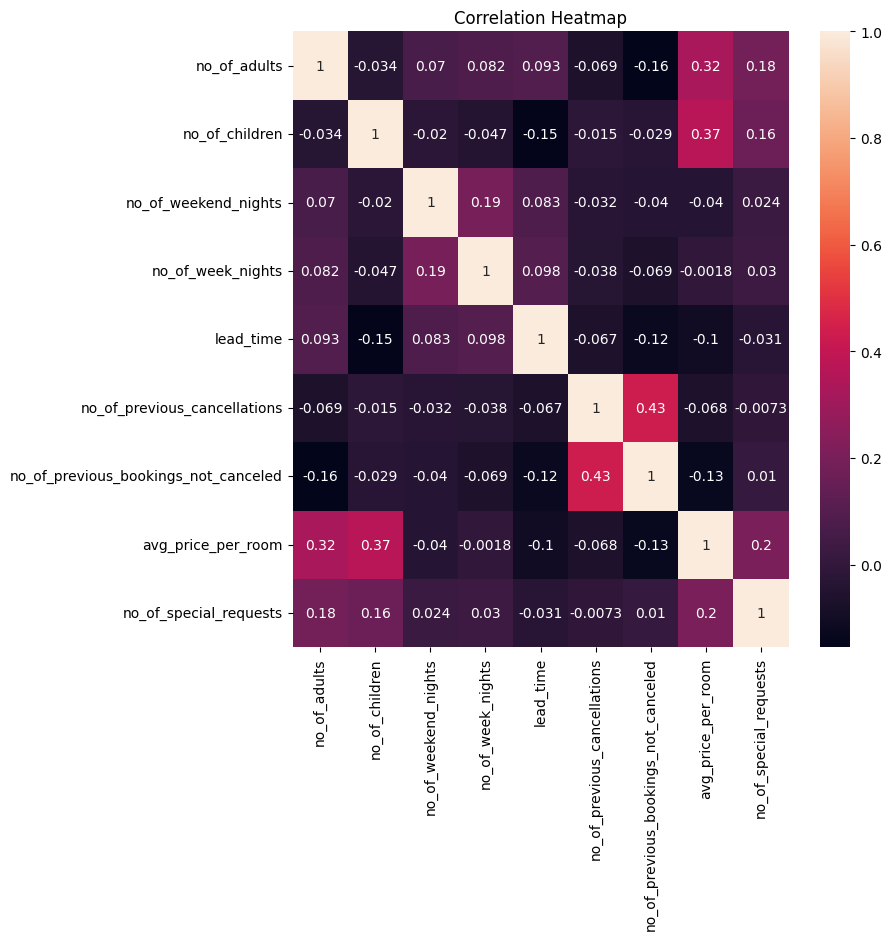

In [124]:
# Check multicollinearity
correlation = reservation[list(reservation.select_dtypes(exclude = ["category","uint8"]).columns)].corr()
plt.figure(figsize=(8,8))
sns.heatmap(correlation,annot=True).set_title("Correlation Heatmap")
plt.show()

In [127]:
reservation = reservation.drop(columns = ['no_of_children','type_of_meal_plan_3','room_type_reserved_6'])

# Model buiding

In [66]:
ct = ColumnTransformer([('scaler', StandardScaler(), list(reservation.select_dtypes(exclude = "uint8").columns))], remainder='passthrough')
X_transformed = ct.fit_transform(reservation.drop("booking_status", axis = 1))
y = reservation["booking_status"]
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.35, random_state=42)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None, predictions=True, random_state=42, classifiers='all')
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

 97%|█████████▋| 28/29 [04:03<00:06,  6.43s/it]

[LightGBM] [Info] Number of positive: 10295, number of negative: 16239
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 26534, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.387993 -> initscore=-0.455757
[LightGBM] [Info] Start training from score -0.455757


100%|██████████| 29/29 [04:03<00:00,  8.40s/it]


In [67]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.83,0.82,0.82,0.83,1.84
LGBMClassifier,0.83,0.82,0.82,0.83,0.38
RandomForestClassifier,0.82,0.80,0.80,0.82,3.77
AdaBoostClassifier,0.80,0.79,0.79,0.80,1.09
BaggingClassifier,0.80,0.79,0.79,0.80,1.27
SVC,0.80,0.79,0.79,0.80,31.98
NuSVC,0.80,0.78,0.78,0.80,40.81
ExtraTreesClassifier,0.80,0.78,0.78,0.79,3.84
LinearSVC,0.79,0.77,0.77,0.79,3.28


In [137]:
ct = ColumnTransformer([('scaler', StandardScaler(), list(reservation.select_dtypes(exclude = "uint8").columns))], remainder='passthrough')
X_transformed = ct.fit_transform(reservation.drop("booking_status", axis = 1))
y = reservation["booking_status"]
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.35, random_state=42)
xgb_model = XGBClassifier(n_estimators = 549, learning_rate = 0.06293551989523104, max_depth = 9, subsample = 0.9556569095216273, colsample_bytree = 0.7795660396888516, gamma = 0.2376827534070651, reg_alpha = 0.0020766520312498218, reg_lambda = 0.013487410465769257, min_child_weight = 10)
xgb_model.fit(X_train, y_train)
y_test_pred = xgb_model.predict(X_test)
y_train_pred = xgb_model.predict(X_train)
y_proba = xgb_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC_AUC:", roc_auc)
print("Train Accuracy", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, average='macro'))
print("Recall:", recall_score(y_test, y_test_pred, average='macro'))
print("F1-Score:", f1_score(y_test, y_test_pred, average='macro'))

ROC_AUC: 0.908691464415451
Train Accuracy 0.8861083892364513
Test Accuracy: 0.8406354983202687
Precision: 0.8330752239843149
Recall: 0.8305270835471568
F1-Score: 0.8317413305990706


In [134]:
#Hyperparameter Tuning
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

ct = ColumnTransformer([('scaler', StandardScaler(), list(reservation.select_dtypes(exclude = "uint8").columns))], remainder='passthrough')
X_transformed = ct.fit_transform(reservation.drop("booking_status", axis = 1))
y = reservation["booking_status"]
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.35, random_state=42)
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 600),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_uniform('gamma', 0, 5),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }
    
    xgb_model = XGBClassifier(**params)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)
print('Best hyperparameters:', study.best_params)
print('Best accuracy:', study.best_value)


[I 2023-10-19 21:34:21,117] A new study created in memory with name: no-name-a6ce76c9-1c02-4d1a-89ce-ae20ed766968
[I 2023-10-19 21:34:22,363] Trial 0 finished with value: 0.8246080627099664 and parameters: {'n_estimators': 387, 'learning_rate': 0.005345197104141387, 'max_depth': 12, 'subsample': 0.38821693136990865, 'colsample_bytree': 0.9560930432320812, 'gamma': 3.862684668386142, 'reg_alpha': 3.230300660465021e-05, 'reg_lambda': 0.003578568237405305, 'min_child_weight': 7}. Best is trial 0 with value: 0.8246080627099664.
[I 2023-10-19 21:34:22,846] Trial 1 finished with value: 0.8212486002239642 and parameters: {'n_estimators': 343, 'learning_rate': 0.04383739814844029, 'max_depth': 4, 'subsample': 0.22967796909404245, 'colsample_bytree': 0.22092162552130087, 'gamma': 2.97104013208068, 'reg_alpha': 0.0008290791239985433, 'reg_lambda': 0.2842329138220312, 'min_child_weight': 3}. Best is trial 0 with value: 0.8246080627099664.
[I 2023-10-19 21:34:23,377] Trial 2 finished with value: 0

[I 2023-10-19 21:34:36,894] Trial 20 finished with value: 0.7958426651735723 and parameters: {'n_estimators': 302, 'learning_rate': 0.00837503352294512, 'max_depth': 3, 'subsample': 0.46443206029802664, 'colsample_bytree': 0.3099014843295123, 'gamma': 2.0115545705450355, 'reg_alpha': 0.03302728997419825, 'reg_lambda': 0.0005968484161830326, 'min_child_weight': 8}. Best is trial 16 with value: 0.8373460246360582.
[I 2023-10-19 21:34:38,242] Trial 21 finished with value: 0.8369960806270996 and parameters: {'n_estimators': 457, 'learning_rate': 0.021627345440646296, 'max_depth': 10, 'subsample': 0.6145830694933937, 'colsample_bytree': 0.7280024698643156, 'gamma': 1.3203507431061492, 'reg_alpha': 0.6858945373430877, 'reg_lambda': 0.018280406800699124, 'min_child_weight': 9}. Best is trial 16 with value: 0.8373460246360582.
[I 2023-10-19 21:34:39,653] Trial 22 finished with value: 0.8353863381858903 and parameters: {'n_estimators': 484, 'learning_rate': 0.018781384542249757, 'max_depth': 10

[I 2023-10-19 21:35:12,177] Trial 40 finished with value: 0.8391657334826428 and parameters: {'n_estimators': 597, 'learning_rate': 0.018478311599777555, 'max_depth': 14, 'subsample': 0.8392784332349876, 'colsample_bytree': 0.7766725883173885, 'gamma': 0.5122696505864576, 'reg_alpha': 0.018029289110447145, 'reg_lambda': 0.007683877033863064, 'min_child_weight': 9}. Best is trial 40 with value: 0.8391657334826428.
[I 2023-10-19 21:35:14,503] Trial 41 finished with value: 0.8393057110862262 and parameters: {'n_estimators': 599, 'learning_rate': 0.01781913721439038, 'max_depth': 14, 'subsample': 0.8498128308172433, 'colsample_bytree': 0.7774937545661438, 'gamma': 0.6794158775634057, 'reg_alpha': 0.02118762335421484, 'reg_lambda': 0.005640086792273354, 'min_child_weight': 9}. Best is trial 41 with value: 0.8393057110862262.
[I 2023-10-19 21:35:16,405] Trial 42 finished with value: 0.8373460246360582 and parameters: {'n_estimators': 541, 'learning_rate': 0.028424116251382567, 'max_depth': 1

[I 2023-10-19 21:35:46,087] Trial 60 finished with value: 0.8372060470324748 and parameters: {'n_estimators': 467, 'learning_rate': 0.02010527075101428, 'max_depth': 13, 'subsample': 0.661710597192002, 'colsample_bytree': 0.7679140100653492, 'gamma': 0.7037186380426963, 'reg_alpha': 0.07064201938627374, 'reg_lambda': 0.009592930474724305, 'min_child_weight': 7}. Best is trial 41 with value: 0.8393057110862262.
[I 2023-10-19 21:35:48,265] Trial 61 finished with value: 0.8381159014557671 and parameters: {'n_estimators': 578, 'learning_rate': 0.024798089077448824, 'max_depth': 12, 'subsample': 0.7412847336194603, 'colsample_bytree': 0.7660457323925621, 'gamma': 0.08932297207168464, 'reg_alpha': 0.004710923205786242, 'reg_lambda': 0.0009722107067559943, 'min_child_weight': 10}. Best is trial 41 with value: 0.8393057110862262.
[I 2023-10-19 21:35:50,361] Trial 62 finished with value: 0.8373460246360582 and parameters: {'n_estimators': 598, 'learning_rate': 0.01716550925165282, 'max_depth': 

[I 2023-10-19 21:36:19,771] Trial 80 finished with value: 0.8382558790593505 and parameters: {'n_estimators': 443, 'learning_rate': 0.047930647812094426, 'max_depth': 12, 'subsample': 0.9209727688162408, 'colsample_bytree': 0.7286807645054054, 'gamma': 0.4203790665910709, 'reg_alpha': 0.0017454654212319938, 'reg_lambda': 0.00904372922195938, 'min_child_weight': 9}. Best is trial 75 with value: 0.8399356103023516.
[I 2023-10-19 21:36:21,516] Trial 81 finished with value: 0.8379059350503919 and parameters: {'n_estimators': 583, 'learning_rate': 0.03439136475714719, 'max_depth': 10, 'subsample': 0.9448401070491745, 'colsample_bytree': 0.8701923875042468, 'gamma': 0.1666317541505227, 'reg_alpha': 0.0007340532521575017, 'reg_lambda': 0.007062394094683549, 'min_child_weight': 8}. Best is trial 75 with value: 0.8399356103023516.
[I 2023-10-19 21:36:23,129] Trial 82 finished with value: 0.8368561030235162 and parameters: {'n_estimators': 584, 'learning_rate': 0.03915076953289552, 'max_depth': 

[I 2023-10-19 21:36:46,480] Trial 100 finished with value: 0.8379059350503919 and parameters: {'n_estimators': 554, 'learning_rate': 0.06222223471921832, 'max_depth': 7, 'subsample': 0.9615042809630183, 'colsample_bytree': 0.7486660904024575, 'gamma': 0.13697265426933686, 'reg_alpha': 0.009262606443790664, 'reg_lambda': 0.018873209726041354, 'min_child_weight': 10}. Best is trial 75 with value: 0.8399356103023516.
[I 2023-10-19 21:36:47,644] Trial 101 finished with value: 0.8379059350503919 and parameters: {'n_estimators': 575, 'learning_rate': 0.04277796266121441, 'max_depth': 6, 'subsample': 0.9428148546754607, 'colsample_bytree': 0.7653354553430884, 'gamma': 0.369400249805267, 'reg_alpha': 0.005689869573526885, 'reg_lambda': 0.010653241718873116, 'min_child_weight': 10}. Best is trial 75 with value: 0.8399356103023516.
[I 2023-10-19 21:36:48,681] Trial 102 finished with value: 0.8378359462486002 and parameters: {'n_estimators': 514, 'learning_rate': 0.07811179291505367, 'max_depth':

[I 2023-10-19 21:37:09,891] Trial 120 finished with value: 0.8395156774916014 and parameters: {'n_estimators': 583, 'learning_rate': 0.06418588570730799, 'max_depth': 8, 'subsample': 0.9344340666307996, 'colsample_bytree': 0.7143394071415211, 'gamma': 0.2864450947422311, 'reg_alpha': 0.011798135264021252, 'reg_lambda': 0.010401096060764356, 'min_child_weight': 10}. Best is trial 104 with value: 0.8404955207166853.
[I 2023-10-19 21:37:11,225] Trial 121 finished with value: 0.8386758118701008 and parameters: {'n_estimators': 588, 'learning_rate': 0.0671709070285382, 'max_depth': 8, 'subsample': 0.9394743588986181, 'colsample_bytree': 0.6627964746975211, 'gamma': 0.2875219912869259, 'reg_alpha': 0.01494757351230535, 'reg_lambda': 0.012118359314814395, 'min_child_weight': 10}. Best is trial 104 with value: 0.8404955207166853.
[I 2023-10-19 21:37:12,663] Trial 122 finished with value: 0.8381159014557671 and parameters: {'n_estimators': 600, 'learning_rate': 0.06132938972905651, 'max_depth':

[I 2023-10-19 21:37:35,577] Trial 140 finished with value: 0.8397956326987682 and parameters: {'n_estimators': 588, 'learning_rate': 0.02995772516770219, 'max_depth': 8, 'subsample': 0.8545563154524649, 'colsample_bytree': 0.7923862036902714, 'gamma': 0.08322316500875057, 'reg_alpha': 0.006903386813837812, 'reg_lambda': 0.010306869403288866, 'min_child_weight': 10}. Best is trial 133 with value: 0.8406354983202687.
[I 2023-10-19 21:37:37,056] Trial 141 finished with value: 0.8379759238521837 and parameters: {'n_estimators': 588, 'learning_rate': 0.02636472091752321, 'max_depth': 8, 'subsample': 0.8850182067765326, 'colsample_bytree': 0.7897222853557696, 'gamma': 0.08572454385242079, 'reg_alpha': 0.006758926808969327, 'reg_lambda': 0.01064825615219573, 'min_child_weight': 10}. Best is trial 133 with value: 0.8406354983202687.
[I 2023-10-19 21:37:38,534] Trial 142 finished with value: 0.8386758118701008 and parameters: {'n_estimators': 581, 'learning_rate': 0.029474359386372, 'max_depth'

[I 2023-10-19 21:37:58,935] Trial 160 finished with value: 0.8386058230683091 and parameters: {'n_estimators': 567, 'learning_rate': 0.04195111705338894, 'max_depth': 8, 'subsample': 0.9294287794491767, 'colsample_bytree': 0.6684560348695281, 'gamma': 0.10626538386831058, 'reg_alpha': 0.0019827277823099075, 'reg_lambda': 0.005245912341761458, 'min_child_weight': 10}. Best is trial 133 with value: 0.8406354983202687.
[I 2023-10-19 21:37:59,976] Trial 161 finished with value: 0.8366461366181411 and parameters: {'n_estimators': 565, 'learning_rate': 0.06579524642074813, 'max_depth': 7, 'subsample': 0.9793929104768336, 'colsample_bytree': 0.6441971052718529, 'gamma': 0.3265096989081726, 'reg_alpha': 0.0024772351689245006, 'reg_lambda': 0.015152488363141687, 'min_child_weight': 10}. Best is trial 133 with value: 0.8406354983202687.
[I 2023-10-19 21:38:01,091] Trial 162 finished with value: 0.8385358342665173 and parameters: {'n_estimators': 571, 'learning_rate': 0.07718712661768456, 'max_de

[I 2023-10-19 21:38:26,696] Trial 180 finished with value: 0.837136058230683 and parameters: {'n_estimators': 492, 'learning_rate': 0.09340574574629971, 'max_depth': 9, 'subsample': 0.8739877814903022, 'colsample_bytree': 0.6873465136378566, 'gamma': 0.5424142566812477, 'reg_alpha': 0.010348911870635032, 'reg_lambda': 0.035310512545469394, 'min_child_weight': 10}. Best is trial 133 with value: 0.8406354983202687.
[I 2023-10-19 21:38:28,398] Trial 181 finished with value: 0.8355963045912654 and parameters: {'n_estimators': 544, 'learning_rate': 0.06569609872033018, 'max_depth': 11, 'subsample': 0.914998253141699, 'colsample_bytree': 0.7852659129185767, 'gamma': 0.17548826680468427, 'reg_alpha': 0.0006175414366584819, 'reg_lambda': 0.024100142597564107, 'min_child_weight': 10}. Best is trial 133 with value: 0.8406354983202687.
[I 2023-10-19 21:38:29,910] Trial 182 finished with value: 0.8345464725643897 and parameters: {'n_estimators': 525, 'learning_rate': 0.07863769606702914, 'max_dept

Best hyperparameters: {'n_estimators': 549, 'learning_rate': 0.06293551989523104, 'max_depth': 9, 'subsample': 0.9556569095216273, 'colsample_bytree': 0.7795660396888516, 'gamma': 0.2376827534070651, 'reg_alpha': 0.0020766520312498218, 'reg_lambda': 0.013487410465769257, 'min_child_weight': 10}
Best accuracy: 0.8406354983202687


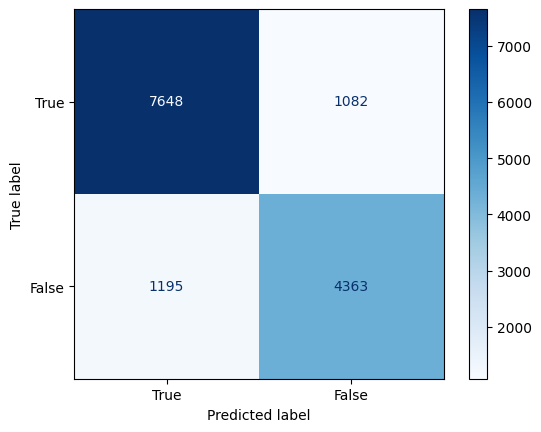

In [145]:
#Ploting Confusion Matrix
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels = [True, False])
cm_display.plot(cmap="Blues")
plt.show()

# Model Validation

In [144]:
from sklearn.model_selection import cross_val_score
xgb_model = XGBClassifier(n_estimators = 549, learning_rate = 0.06293551989523104, max_depth = 9, subsample = 0.9556569095216273, colsample_bytree = 0.7795660396888516, gamma = 0.2376827534070651, reg_alpha = 0.0020766520312498218, reg_lambda = 0.013487410465769257, min_child_weight = 10)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_model, X_transformed, y, cv=cv, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())
print("Standard deviation:", cv_scores.std())

Cross-validation scores: [0.83600735 0.83502756 0.838927   0.84076433 0.83084272]
Mean cross-validation score: 0.8363137914035992
Standard deviation: 0.0034151729034153583
